In [67]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.logger import setup_logger
from pathlib import Path
from typing import List
import numpy as np
import os
import cv2
import re
import imutils
%matplotlib inline
from matplotlib import pyplot as plt
import pytesseract

from alice.config import PROCESSING_INPUT_DIR
from alice.predict import predict_masks
from alice.visualise import visualise_mask
from alice.utils import *
from collections import OrderedDict
from itertools import zip_longest
from imutils import perspective
from typing import List
from operator import attrgetter

In [2]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2

In [3]:
paths = [PROCESSING_INPUT_DIR / f'011245996_additional_{i}.jpeg' for i in range(1,5)]

# paths = [PROCESSING_INPUT_DIR / f'Tri434014_additional_{i}.JPG' for i in range(1,5)]



In [4]:
class Quadrilateral:
    def __init__(self, vertices, is_approx=False):
        # Closest point to the bottom of the canvas
        self.closest_point = self.get_closest_point(vertices)
        
        # Vertices are assigned to a,b,c,d
        # A will be the closest point (with the maximum y value), with the points
        # ordered counter clockwise, with b being the next corner counter clockwise
        # A & C will be opposite each other; B & D opposite
        self.vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, self.closest_point)))
        
        # Loop through vertices, creating edges names a_b, b_c etc.,
        self.edges = OrderedDict([(
            f'{k1}_{k2}', LineString([
                self.vertices[k1], 
                self.vertices[k2]
            ])) for k1, k2 in pairwise(list(self.vertices.keys()))
        ])
        self.angles = self.get_corner_angles()

    @staticmethod
    def get_closest_point(vertices):
        """
        Get point with lowest y value
        """
        vertices = np.array(vertices)
        return tuple(vertices[np.argmax(vertices[:, 1])])        

    def get_corner_angles(self):
        angles = {}
        for e1, e2 in pairwise(list(self.edges.keys())):
            # The corner will be duplicated by the edge names: tl_tr, tr_br => tr
            vertice = Counter(e1.split('_') + e2.split('_')).most_common(1)[0][0]
            angles[vertice] = calculate_angle_between_lines(self.edges[e1], self.edges[e2])  
        return angles

    def is_wellformed_label_shape(self):
        """
        Validate the label shape, 4 corners & opposite angles be within 15 degrees
        """
        valid_angle = 15
        if len(self.vertices) != 4:
            return False
        oppos_corners = [('a', 'c'), ('b', 'd')]
        max_angle_diff = max([abs(self.angles[i] - self.angles[j]) for i,j in oppos_corners])  
        return max_angle_diff < valid_angle

    def visualise(self, image):
        for edge in self.edges.values():
            p = np.array(edge.coords).astype(np.int32)
            cv2.line(image, p[0], p[1], (0, 255, 0), 5)
        for point in self.vertices.values():
            pt = np.array(point).astype(np.int32)
            cv2.circle(image, pt, 5, (255,0,0), 5)
        return image

    def get_perspective_transformed(self, image):

        max_x = round(max([self.edges['a_b'].length, self.edges['c_d'].length])) - 1
        max_y = round(max([self.edges['b_c'].length, self.edges['d_a'].length])) - 1
        
        dest = np.float32([
            (0, max_x), #A
            (0, 0), #B
            (max_y, 0), #C
            (max_y, max_x) #D
        ])
        
        src = np.float32(list(self.vertices.values()))
        M = cv2.getPerspectiveTransform(src, dest)
        
        return cv2.warpPerspective(image,M,(max_y, max_x),flags=cv2.INTER_LINEAR)           

class Mask():
    def __init__(self, data: np.array):
        self._data = data

    @property
    def height(self):
        return self._data.shape[0]

    @property
    def width(self):
        return self._data.shape[1]  

    @property
    def y_midpoint(self):
        """
        Vertical midpoint of a mask
        """        
        return sum([min(np.where(self._data == True)[0]), max(np.where(self._data == True)[0])]) / 2 
        
    def contour(self, epsilon=5):
        contours, _ = cv2.findContours(self._data.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Simplify contour - otherwise approx_best_fit_ngon takes many seconds
        # Requires low epsilon < 10 otherwise approx vertices are out
        if epsilon:
            contours = cv2.approxPolyDP(contours[0], epsilon, True)        
        return contours

    def edges(self) -> np.array:
        """
        Get edges of a mask
        """
        # Diff will reduce width by 1, so prepend with extra column of 0s
        return np.diff(self._data, prepend=np.zeros(self.height)[0])  

    def edge_points(self) -> List:   
        """
        Get the edges 
        """    
        # Find the indices of True values in the mask, and return row col (points)
        return [(col, row) for row, col in np.argwhere(self.edges())]  

    def to_quadrilateral(self):
        """
        Get quadrilateral around mask
        """
        vertices = approx_best_fit_ngon(self.contour())
        quad = Quadrilateral(vertices)
        if quad.is_wellformed_label_shape():        
            return quad
        
        # TODO: Log
        # We want to get the two edges intersection at point A (closest corner)
        closest_edges = [quad.edges[e] for e in ['a_b', 'd_a']]
        vertices = approx_quadrilateral_from_closest_edges(closest_edges, self)
        approx_quad = Quadrilateral(vertices, is_approx=True)
        if approx_quad.is_wellformed_label_shape():
            return approx_quad  

        # TODO: Log 

class AngledView():

    """
    A view of the specimen 
    """

    min_mask_size = 1500
    
    def __init__(self, path: Path):
        # FIXME: Reading image twice
        self.image = cv2.imread(str(path))
        self.predictions = predict_masks(path)
        self.masks = self.masks_from_predictions(self.predictions)
        self.quads = self.masks_to_quadrilaterals()

    def masks_from_predictions(self, predictions):
        masks = self.predictions.get('instances').to("cpu").pred_masks.numpy()
        masks = self.filter_small_masks(masks)
        masks = self.remove_overlaps(masks)
        masks = [Mask(m) for m in masks]
        # Sort by mask y midpoint
        masks.sort(key = attrgetter('y_midpoint'))
        return masks

    def masks_to_quadrilaterals(self):
        return [mask.to_quadrilateral() for mask in self.masks]
        
    def filter_small_masks(self, masks: np.array):
        return [m for m in masks if np.count_nonzero(m) > self.min_mask_size]

    def remove_overlaps(self, masks: np.array):
        # FIXME: Doesn't work in Ariana's code
        return masks

    def __len__(self):
        return len(self.masks)

class Specimen():
    def __init__(self, paths: List[Path]):
        self.views = [AngledView(p) for p in paths]
        # TODO: Get the mean of the mask count, and drop any views not corresponding to mean
        # TODO: Log error

    def __iter__(self):
        for view in self.views:
            yield view

    def __len__(self):
        return len(self.views)

    def __getitem__(self, i):
        return self.views[i]

      

specimen = Specimen(paths)

/Users/ben/Projects/NaturalHistoryMuseum/ALICE/ALICE/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
view = specimen[0]

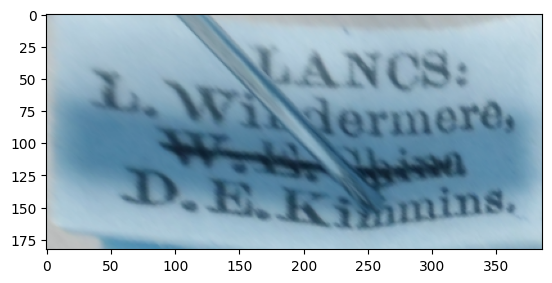

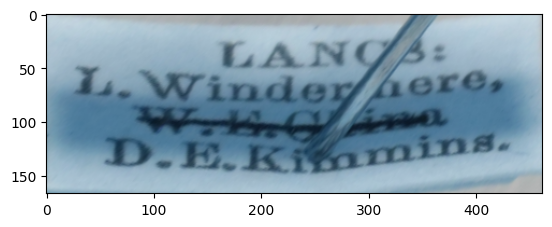

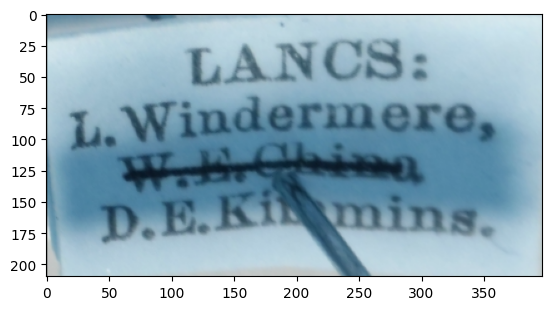

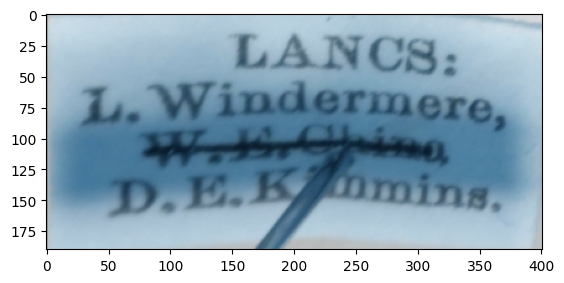

In [279]:
# TODO: Check all views have the same number of images

num_labels_per_view = np.array([len(view) for view in specimen])
is_equal_num_per_view = len(np.unique(num_labels_per_view)) == 1

label_index = 1

images = []

for i, view in enumerate(specimen):

    # If we don't have the same  number of labels per view, drop the view not matching the median
    if not is_equal_num_per_view and len(view) != np.median(num_labels_per_view):
        print("SKIPPING - not same num")
        continue

    
    img = deepcopy(view.image)
    quad = view.quads[label_index]

    transformed = quad.get_perspective_transformed(view.image)

    # Longest edge should be the bottom
    h, w = transformed.shape[:2]
    if h > w:
        rotate_angle = -90
    
    # Align all the same way - rotate 90 degrees x position
    transformed = imutils.rotate_bound(transformed, rotate_angle + (90 * i))

    # img = quad.visualise(img)
    plt.imshow(transformed)
    plt.show() 

    images.append(transformed)
    

    


24.0
227.03523955544875
25.0
233.94443784796422
26.0
295.7354894228293
27.0
257.6606295109907
27.0
257.6509489225945


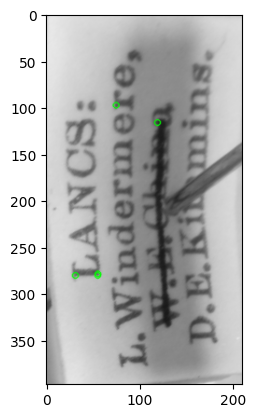

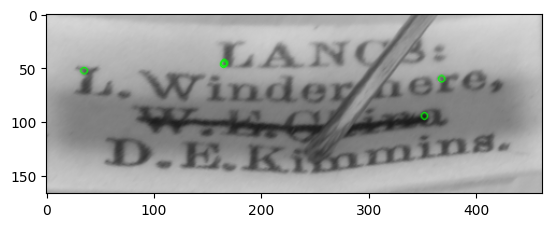

(<matplotlib.image.AxesImage at 0x158f9df00>, None)

In [220]:
# https://pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
# https://towardsdatascience.com/improving-your-image-matching-results-by-14-with-one-line-of-code-b72ae9ca2b73
# https://stackoverflow.com/questions/44457064/displaying-stitched-images-together-without-cutoff-using-warpaffine/44459869#44459869
image1 = images[2]
image2 = images[1]
image3 = images[0]
image4 = images[3]

# Convert to grayscale.
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
height, width = img1.shape

# # Create ORB detector with 5000 features.
# orb_detector = cv2.ORB_create(10000)



# # Find keypoints and descriptors.
# # The first arg is the image, second arg is the mask
# #  (which is not required in this case).
# kpts1, desc1 = orb_detector.detectAndCompute(img1, None)
# kpts2, desc2 = orb_detector.detectAndCompute(img2, None) 

# detector = cv2.SIFT_create()
# TODO: scaleFactor=1.2, nLevels=8, edgeThreshold=10, patchSize=31, fastThreshold=20
detector = cv2.ORB_create()
detector.setMaxFeatures(1000)
# Create SIFT detector
# sift = cv2.SIFT_create()

# Find keypoints and descriptors
kp1, descriptors1 = detector.detectAndCompute(image1, None)
kp2, descriptors2 = detector.detectAndCompute(image2, None)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

matches = matcher.match(descriptors1, descriptors2)

# Sort matches on the basis of their Hamming distance.
# dists = [m.distance for m in matches]
# lst = [matches[i] for i in np.argsort(dists)]
# matches = tuple(lst)

matches = sorted(matches, key = lambda x:x.distance)
# matches = matches[:2] + matches[3:15]

matches = matches[:5]

for m in matches:
    print(m.distance)
    x1,y1 = kp1[m.queryIdx].pt
    x2,y2 = kp2[m.trainIdx].pt
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    print(distance)

    
    

no_of_matches = len(matches)

# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))

for i, match in enumerate(matches):
    p1[i, :] = kp1[match.queryIdx].pt
    p2[i, :] = kp2[match.trainIdx].pt

matched1 = []
matched2 = []

for m in matches:
    matched1.append(kp1[m.queryIdx])
    matched2.append(kp2[m.trainIdx])
    
# # Find the homography matrix.
# homography, mask = cv2.findHomography(p2, p1, cv2.RANSAC)

# # Use this matrix to transform the
# # colored image wrt the reference image.
# transformed_img = cv2.warpPerspective(img2, homography, (width, height))
# plt.imshow(transformed_img), plt.show()

img1 = cv2.drawKeypoints(img1, matched1, None, color=(0,255,0), flags=0)
plt.imshow(img1), plt.show()

img2 = cv2.drawKeypoints(img2, matched2, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

# # Initialize a brute force matcher
# bf = cv2.BFMatcher()

# # Match descriptors
# matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# # Apply ratio test to keep good matches
# good_matches = []
# for m, n in matches:
#     if m.distance < 0.75 * n.distance:
#         good_matches.append(m)

# # Draw matched keypoints
# matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=2)

# image1_with_keypoints = cv2.drawKeypoints(image1, keypoints1, None)
# image2_with_keypoints = cv2.drawKeypoints(image2, keypoints2, None)

# plt.imshow(image1_with_keypoints)
# plt.show()
# plt.imshow(image2_with_keypoints)
# plt.show()



# # detector = cv2.ORB_create(10000)
# kpts1 = detector.detect(img1, None)
# kpts2 = detector.detect(img2, None)

# descriptor = cv2.xfeatures2d.BEBLID_create(0.75)

# kpts1, desc1 = descriptor.compute(img1, kpts1)
# kpts2, desc2 = descriptor.compute(img2, kpts2)

# Match features between the two images.
# We create a Brute Force matcher with
# Hamming distance as measurement mode.
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Match the two sets of descriptors.
# matches = matcher.match(d1, d2)

# matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)
# nn_matches = matcher.knnMatch(desc1, desc2, 2)
# matched1 = []
# matched2 = []
# nn_match_ratio = 0.5  # Nearest neighbor matching ratio
# for m, n in nn_matches:
#     if m.distance < nn_match_ratio * n.distance:
#         matched1.append(kpts1[m.queryIdx])
#         matched2.append(kpts2[m.trainIdx])

# # print(keypoints1)        
# print(type(matched1))
# print(type(keypoints1))       

# print(matches)

# # draw only keypoints location,not size and orientation
# img1 = cv2.drawKeypoints(img1, matched1, None, color=(0,255,0), flags=0)
# plt.imshow(img1), plt.show()

# # draw only keypoints location,not size and orientation
# img2 = cv2.drawKeypoints(img2, matched2, None, color=(0,255,0), flags=0)
# plt.imshow(transformed_img), plt.show()
# plt.imshow(image2), plt.show()
# plt.imshow(image1), plt.show()



# blended_image = cv2.addWeighted(image1, 0.5, transformed_img, 0.5, 0)
# plt.imshow(blended_image), plt.show()


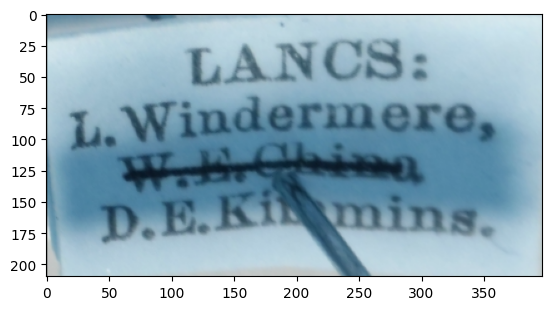

(<matplotlib.image.AxesImage at 0x158a124d0>, None)

In [213]:
# img = deepcopy(image2)
# gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# corners = cv2.goodFeaturesToTrack(gray_img, maxCorners=50,      qualityLevel=0.02, minDistance=20)
# corners = np.float32(corners)

# for item in corners:
#     x, y = item[0]
#     cv2.circle(img, (int(x), int(y)), 6, (0, 255, 0), -1)

# normalized_image1 = cv2.equalizeHist(img1)
# normalized_image2 = cv2.equalizeHist(image2)

image1 = images[2]

# Convert to grayscale.
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# blurred = cv2.GaussianBlur(img1, (7, 7), 0)
# # Run thresholding, returning the masked image and return code
# # ret, img_masked = cv2.threshold(img1, 0, 20, cv2.THRESH_TOZERO)

kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]]) 

sharpened = cv2.filter2D(img1, -1, kernel)

plt.imshow(images[2]), plt.show()

In [574]:
from alice.config import ASSETS_DIR
from imutils.object_detection import non_max_suppression

class EastTextDetection():

    model_path = str(ASSETS_DIR / "frozen_east_text_detection.pb")

    layer_names = [
    	"feature_fusion/Conv_7/Sigmoid",
    	"feature_fusion/concat_3"
    ]

    confidence = 0.5
    
    def __init__(self):
        self.net = cv2.dnn.readNet(self.model_path)

    def detect(self, image):
        h, w = image.shape[:2]
        new_h = self._scale_dimension(h)
        new_w = self._scale_dimension(w)
        
        w_ratio = w / float(new_w)
        h_ratio = h / float(new_h)

        image = cv2.resize(image, (new_w, new_h))

        # construct a blob from the image and then perform a forward pass of
        # the model to obtain the two output layer sets
        blob = cv2.dnn.blobFromImage(image, 1.0, (new_w, new_h),
        	(123.68, 116.78, 103.94), swapRB=True, crop=False)
        start = time.time()
        net.setInput(blob)
        (scores, geometry) = net.forward(self.layer_names)      
        boxes = self._get_bounding_boxes(scores, geometry)
        boxes = list(self._scale_bounding_boxes(boxes, w_ratio, h_ratio))
        lines = self._get_text_lines(boxes)
        return boxes, lines
        

    def _scale_dimension(self, dim: int):
        # image height and width should be multiple of 32
        return dim + (32 - (dim % 32))

    def _get_bounding_boxes(self, scores, geometry):        
        # grab the number of rows and columns from the scores volume, then
        # initialize our set of bounding box rectangles and corresponding
        # confidence scores
        (num_rows, num_cols) = scores.shape[2:4]
        rects = []
        confidences = []
        
        # loop over the number of rows
        for y in range(0, num_rows):
            # extract the scores (probabilities), followed by the geometrical
            # data used to derive potential bounding box coordinates that
            # surround text
            scores_data = scores[0, 0, y]
            x_data0 = geometry[0, 0, y]
            x_data1 = geometry[0, 1, y]
            x_data2 = geometry[0, 2, y]
            x_data3 = geometry[0, 3, y]
            angles_data = geometry[0, 4, y]
            
            # loop over the number of columns
            for x in range(0, num_cols):
                # if score does not have sufficient probability, ignore it
                if scores_data[x] < self.confidence:
                    continue
                
                # compute the offset factor as our resulting feature maps will
                # be 4x smaller than the input image
                (offset_x, offset_y) = (x * 4.0, y * 4.0)
                
                # extract the rotation angle for the prediction and then
                # compute the sin and cosine
                angle = angles_data[x]
                
                cos = np.cos(angle)
                sin = np.sin(angle)
                
                # use the geometry volume to derive the width and height of
                # the bounding box
                h = x_data0[x] + x_data2[x]
                w = x_data1[x] + x_data3[x]
                
                # compute both the starting and ending (x, y)-coordinates for
                # the text prediction bounding box
                end_x = int(offset_x + (cos * x_data1[x]) + (sin * x_data2[x]))
                end_y = int(offset_y - (sin * x_data1[x]) + (cos * x_data2[x]))
                start_x = int(end_x - w)
                start_y = int(end_y - h)
                
                # add the bounding box coordinates and probability score to
                # our respective lists
                rects.append((start_x, start_y, end_x, end_y))
                confidences.append(scores_data[x])
        
        # apply non-maxima suppression to suppress weak, overlapping bounding boxes
        rects = non_max_suppression(np.array(rects), probs=confidences)  
        return rects

    def _scale_bounding_boxes(self, boxes, w_ratio, h_ratio):
        # loop over the bounding boxes
        for (start_x, start_y, end_x, end_y) in boxes:
            # scale the bounding box coordinates based on the respective
            # ratios
            start_x = int(start_x * w_ratio)
            start_y = int(start_y * h_ratio)
            end_x = int(end_x * w_ratio)
            end_y = int(end_y * h_ratio)
            
            yield (start_x, start_y), (end_x, end_y)

    def _get_text_lines(self, boxes):
        groups = self._horizontally_grouped_boxes(boxes)
        lines = []
        for group in groups:
        
            boxes_array = np.array(group)
            
            # Find the minimum and maximum coordinates along the x and y axes
            min_x = np.min(boxes_array[:, :, 0])
            min_y = np.min(boxes_array[:, :, 1])
            max_x = np.max(boxes_array[:, :, 0])
            max_y = np.max(boxes_array[:, :, 1])

            # FIXME: sort by y again
            # Create a bounding rectangle using the min and max coordinates
            lines.append([
                (min_x, min_y),
                (max_x, max_y),
            ])
            
        lines = sorted(lines, key=lambda x: x[0][1])
        return np.array(lines)
            

    @staticmethod
    def _horizontally_grouped_boxes(boxes):
        """
        Group boxes horizontally, treating their y coords as intervals
        """
        groups = []
        boxes = np.array(boxes)
        
        # Iterate through intervals to form groups
        for box in boxes:
            group_found = False
            interval = pd.Interval(*box[:, 1], closed='both')    
            for group in groups:
                if any(interval.overlaps(pd.Interval(*group_box[:, 1], closed='both')) for group_box in group):
                    group.append(box)
                    group_found = True
                    break
            
            if not group_found:
                groups.append([box])    

        return groups


image = images[2].copy()

# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.equalizeHist(image)


east = EastTextDetection()   

image1 = images[2].copy()
boxes1, lines1 = east.detect(image1)

# image2 = cv2.fastNlMeansDenoisingColored(image2, None, h=10, templateWindowSize=7, searchWindowSize=21)

image2 = images[0].copy()
boxes2, lines2 = east.detect(image2)

print(lines2)



# for start, end in boxes1:
#     cv2.rectangle(image1, start, end, (0, 255, 0), 1)

# for start, end in lines1:
#     cv2.rectangle(image1, start, end, (0, 255, 255), 2)
    
# for start, end in boxes2:
#     cv2.rectangle(image2, start, end, (0, 255, 0), 1)

# for start, end in lines2:
#     cv2.rectangle(image2, start, end, (0, 255, 255), 2)
    
# plt.imshow(image2), plt.show()
# plt.imshow(image1), plt.show()

# print(lines2)

# cv2.imwrite('image1.jpg', image1)
# cv2.imwrite('image2.jpg', image2)



[[[176  22]
  [326  61]]

 [[193  62]
  [367  91]]

 [[ 87 131]
  [366 162]]]


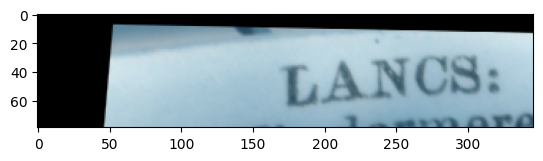

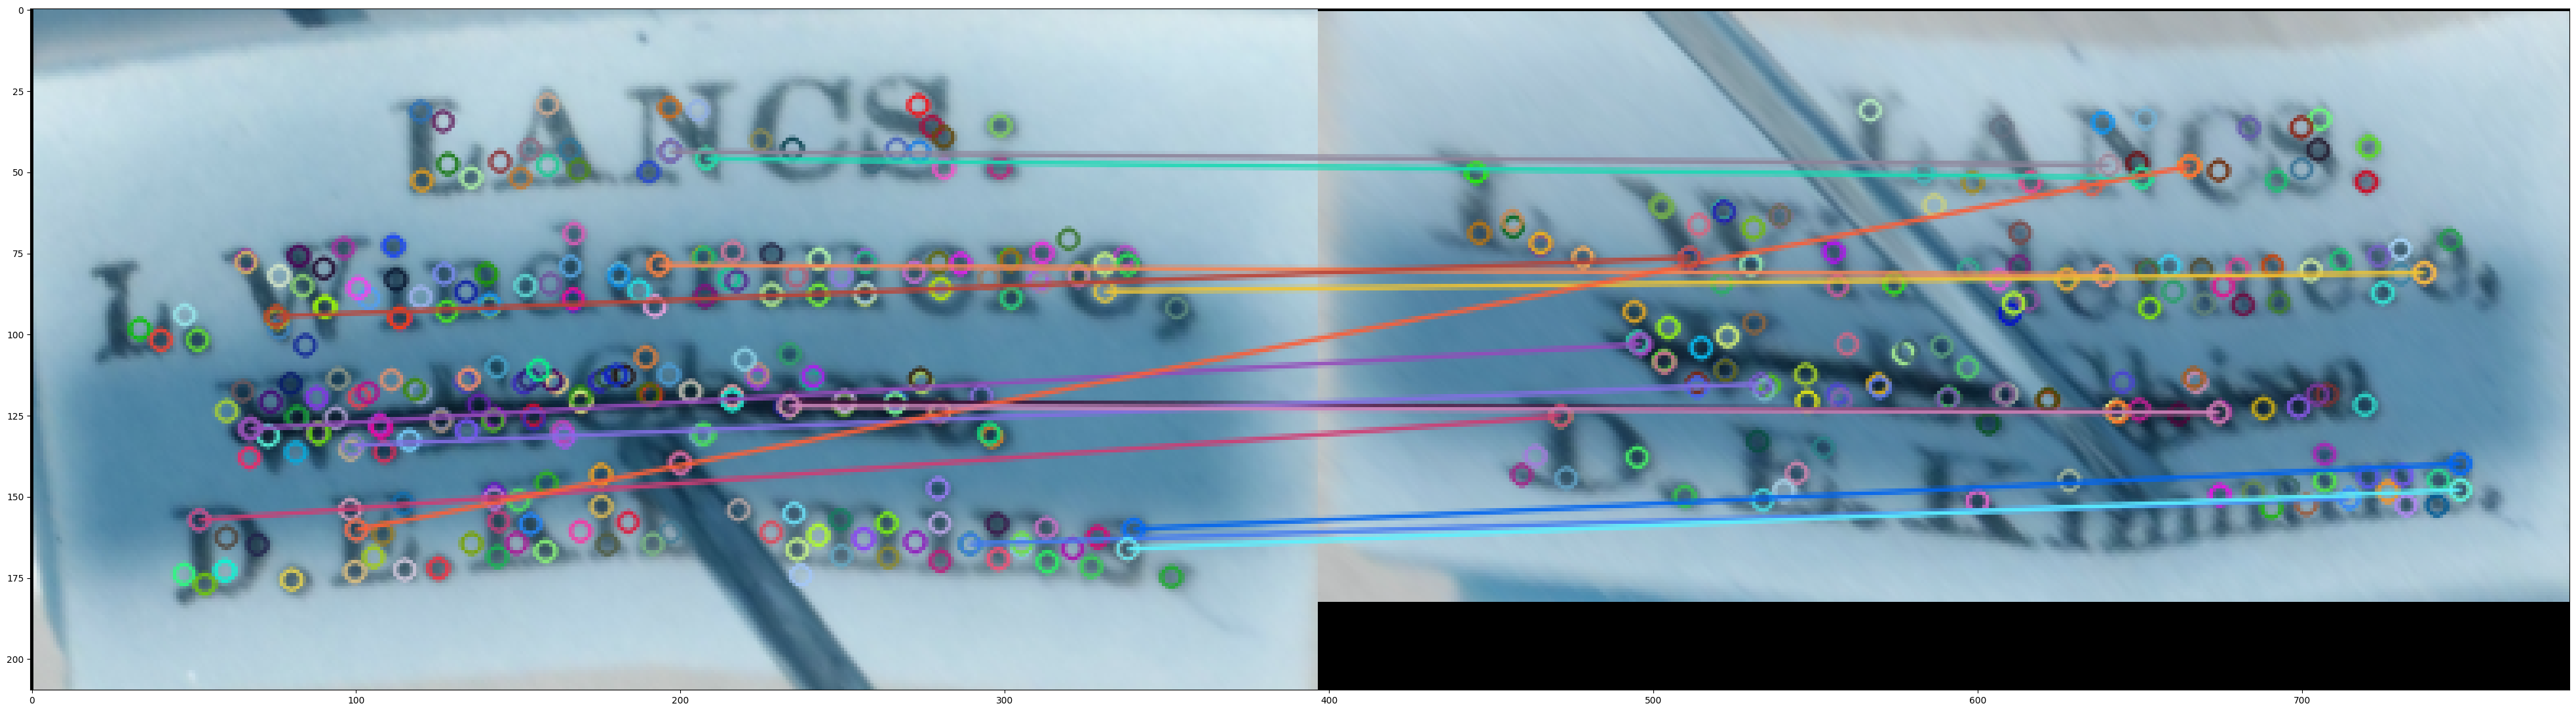

[ WARN:0@149119.619] global loadsave.cpp:248 findDecoder imread_('image.jpg'): can't open/read file: check file path/integrity


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

In [575]:


# Convert to grayscale.
img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) 
img2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

def sift_detector(image1, image2):
    # Initialize SIFT detector
    sift = cv2.SIFT_create(1000)
    
    # Find keypoints and descriptors for both images
    keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, None)
    
    # Convert descriptors to float32
    descriptors1 = descriptors1.astype(np.float32)
    descriptors2 = descriptors2.astype(np.float32)
    
    # Create a Brute Force Matcher
    bf = cv2.BFMatcher()
    
    # Match descriptors
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Extract corresponding keypoints
    src_pts = np.float32([keypoints1[match.queryIdx].pt for match in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in good_matches]).reshape(-1, 1, 2)

    return src_pts, dst_pts, keypoints1, keypoints2, good_matches

def akaze_detector(image1, image2):
    # Initialize SURF detector
    akaze = cv2.AKAZE_create()
    
    # Find keypoints and descriptors for both images
    keypoints1, descriptors1 = akaze.detectAndCompute(image1, None)
    keypoints2, descriptors2 = akaze.detectAndCompute(image2, None)
    
    # Create a Brute Force Matcher
    bf = cv2.BFMatcher()
    
    # Match descriptors
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Extract corresponding keypoints
    src_pts = np.float32([keypoints1[match.queryIdx].pt for match in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in good_matches]).reshape(-1, 1, 2) 

    return src_pts, dst_pts, keypoints1, keypoints2, good_matches
    
def orb_detector(image1, image2):
    
    matches_bound=0.9
    max_no_matches=100
    
    # Create ORB detector with 5000 features.
    # orb_detector = cv2.ORB_create(5000, scoreType=cv2.ORB_FAST_SCORE, edgeThreshold=20, patchSize=50, nlevels=20, fastThreshold=20)

    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(image1, None)
    kp2, d2 = orb_detector.detectAndCompute(image2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    
    
    # Sort matches on the basis of their Hamming distance.
    dists = [m.distance for m in matches]
    lst = [matches[i] for i in np.argsort(dists)]
    matches = tuple(lst)
    
    # Take the top 90 % matches forward.
    matches = matches[: int(len(matches) * matches_bound)]
    
    # Filter matches (ASJ edit):
    
    lines, new_index = filter_matches_new(matches, kp1, kp2, img1)
    
    lines_filtered = np.array(lines)[new_index]
    
    matches = tuple([m for i, m in enumerate(matches) if i in new_index])
    
    no_of_matches = len(matches)
    
    if no_of_matches > max_no_matches:
        matches = matches[:max_no_matches]
        no_of_matches = len(matches)
        lines_filtered = lines_filtered[:max_no_matches]
    
    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    
    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    return p1, p2, kp1, kp2, matches

p1, p2, kp1, kp2, matches = akaze_detector(img1, img2)        

# Find the homography matrix.
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# Use this matrix to transform the
# colored image wrt the reference image.
transformed_img = cv2.warpPerspective(image1, homography, (width, height))

plt.imshow(transformed_img), plt.show()
# plt.imshow(image2), plt.show()

img3 = cv2.drawMatches(image1,kp1,image2,kp2,matches,None)
plt.figure(figsize = (50,20))
plt.imshow(img3, 'gray')
plt.show()


# Tomorrow: You can mask particular image

import cv2
import numpy as np

# Load the image
image = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)

# Create a binary mask of the same size as the image
mask = np.zeros_like(image, dtype=np.uint8)

# Define the region of interest (ROI) to be masked
roi_x1, roi_y1 = 100, 100  # Top-left corner
roi_x2, roi_y2 = 300, 300  # Bottom-right corner

# Set the ROI region to be white in the mask
mask[roi_y1:roi_y2, roi_x1:roi_x2] = 255

# Apply the mask to the image
masked_image = cv2.bitwise_and(image, mask)

# Initialize ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors using ORB on the masked image
keypoints, descriptors = orb.detectAndCompute(masked_image, None)

# Draw keypoints on the masked image
masked_image_with_keypoints = cv2.drawKeypoints(masked_image, keypoints, None, color=(0, 255, 0))

# Display the original image, masked image, and masked image with keypoints
cv2.imshow("Original Image", image)
cv2.imshow("Masked Image", masked_image)
cv2.imshow("Masked Image with Keypoints", masked_image_with_keypoints)
cv2.waitKey(0)
cv2.destroyAllWindows()





# # Initialize ORB detector
# orb = cv2.ORB_create()

# # Find keypoints and descriptors for both images
# ref_kps, ref_desc = orb.detectAndCompute(ref_image, None)
# keypoints2, descriptors2 = orb.detectAndCompute(image_to_align, None)

# # Create a Brute Force Matcher
# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# # Match descriptors
# matches = bf.match(descriptors1, descriptors2)

# # Sort the matches by distance
# matches = sorted(matches, key=lambda x: x.distance)

# # Take top N matches
# N = 10
# good_matches = matches[:N]

# # Extract corresponding keypoints
# src_pts = np.float32([keypoints1[match.queryIdx].pt for match in good_matches]).reshape(-1, 1, 2)
# dst_pts = np.float32([keypoints2[match.trainIdx].pt for match in good_matches]).reshape(-1, 1, 2)

# # Calculate Homography
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# # Warp the first image to the perspective of the second image
# h, w = image1_grey.shape
# warped_image = cv2.warpPerspective(image1, M, (w, h))

# # Combine the two images by blending
# # blended_image = cv2.addWeighted(image2, 0.5, warped_image, 0.5, 0)

# warped_image_resized = cv2.resize(warped_image, (image2.shape[1], image2.shape[0]))

# # Combine the two images by blending
# blended_image = cv2.addWeighted(image2, 0.5, warped_image_resized, 0.5, 0)

# plt.imshow(warped_image), plt.show()
# plt.imshow(blended_image), plt.show()





    # # Match features between the two images.
    # # We create a Brute Force matcher with
    # # Hamming distance as measurement mode.
    # matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # # Match the two sets of descriptors.
    # matches = matcher.match(d1, d2)

    # # Sort matches on the basis of their Hamming distance.
    # dists = [m.distance for m in matches]
    # lst = [matches[i] for i in np.argsort(dists)]
    # matches = tuple(lst)

    # # Take the top 90 % matches forward.
    # matches = matches[: int(len(matches) * matches_bound)]

    # # Filter matches (ASJ edit):

    # lines, new_index = filter_matches_new(matches, kp1, kp2, img1)

    # lines_filtered = np.array(lines)[new_index]

    # matches = tuple([m for i, m in enumerate(matches) if i in new_index])

    # no_of_matches = len(matches)

    # if no_of_matches > max_no_matches:
    #     matches = matches[:max_no_matches]
    #     no_of_matches = len(matches)
    #     lines_filtered = lines_filtered[:max_no_matches]



In [ ]:
p1, p2 = lines1[1]
h, w = image1.shape[:2]

x1, y1 = p1
x2, y2 = p2

x1 -= 50
x2 += 50
y1 -= 20
y2 += 20

roi1 = image1[y1:y2, x1:x2]

p1, p2 = lines2[0]
h, w = image2.shape[:2]

x1, y1 = p1
x2, y2 = p2

x1 -= 50
x2 += 50
y1 -= 20
y2 += 20


roi2 = image2[y1:y2, x1:x2]


# w,h = image1.shape[:2]
# print(w)

# roi1 = image1[p1[1]:p2[1], 0:w]

# w,h = image2.shape[:2]

# print(w)

# p1, p2 = lines2[2]
# roi2 = image2[p1[1]:p2[1], 0:w]

plt.imshow(roi1), plt.show()    
plt.imshow(roi2), plt.show()  

def orb_detector(image1, image2):
    
    matches_bound=0.9
    max_no_matches=100
    
    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(10, scoreType=cv2.ORB_FAST_SCORE, edgeThreshold=20, patchSize=5, nlevels=2, fastThreshold=5)

    # Create ORB detector with 5000 features.
    # orb_detector = cv2.ORB_create(50)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(image1, None)
    kp2, d2 = orb_detector.detectAndCompute(image2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    # Sort matches on the basis of their Hamming distance.
    dists = [m.distance for m in matches]
    lst = [matches[i] for i in np.argsort(dists)]
    matches = tuple(lst)
    
    # Take the top 90 % matches forward.
    matches = matches[: int(len(matches) * matches_bound)]
    
    # Filter matches (ASJ edit):
    
    # lines, new_index = filter_matches_new(matches, kp1, kp2, img1)
    
    # lines_filtered = np.array(lines)[new_index]
    
    # matches = tuple([m for i, m in enumerate(matches) if i in new_index])
    
    no_of_matches = len(matches)
    
    if no_of_matches > max_no_matches:
        matches = matches[:max_no_matches]
        no_of_matches = len(matches)
        lines_filtered = lines_filtered[:max_no_matches]
    
    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    print(no_of_matches)
    
    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    return p1, p2, kp1, kp2, matches

p1, p2, kp1, kp2, matches = akaze_detector(roi1, roi2)

# Find the homography matrix.
# homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

# # Use this matrix to transform the
# # colored image wrt the reference image.
# height, width = roi1.shape[:2]

# transformed_img = cv2.warpPerspective(roi1, homography, (width, height))

# plt.imshow(transformed_img), plt.show()
# plt.imshow(image2), plt.show()

# print(len(kp1))
# print(len(matches))


img3 = cv2.drawMatches(roi1,kp1,roi2,kp2,matches,None)
plt.figure(figsize = (50,20))
plt.imshow(img3, 'gray')
plt.show()
    


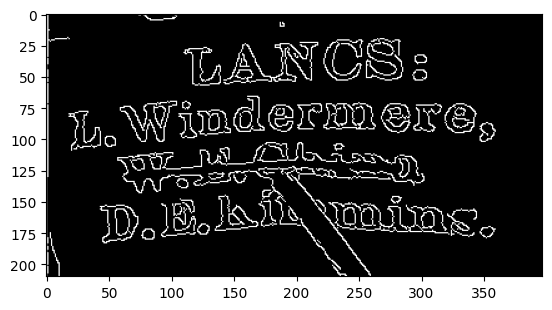

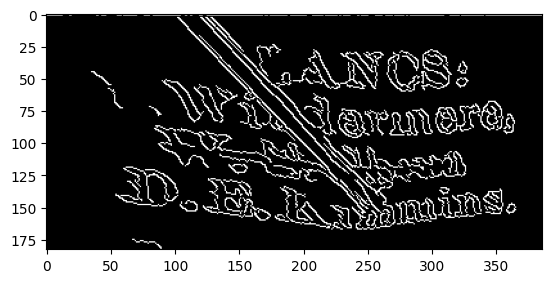

In [565]:
edges = cv2.Canny(image1,50,200)
plt.imshow(edges, 'gray')
plt.show()

edges = cv2.Canny(image2,50,200)
plt.imshow(edges, 'gray')
plt.show()

In [327]:
sorted_boxes = sorted(boxes, key=lambda box: (box[0][0], box[0][1]))

print(boxes)
boxes = np.array(boxes)

intervals = boxes[:, :, 1]

# print([(l[i-1],t) for i,t in enumerate(l) if set(range(t[0],t[1])).intersection(range(l[i-1][0],l[i-1][1]))])

# Sort intervals based on start values
sorted_intervals = intervals[np.argsort(intervals[:, 0])]

# Initialize an empty list to store groups
groups = []

# Iterate through sorted intervals to form groups
for interval in sorted_intervals:
    if not any(np.any((interval[0] <= group[:, 1]) & (interval[1] >= group[:, 0])) for group in groups):
        groups.append(interval)
    else:
        for group in groups:
            if np.any((interval[0] <= group[:, 1]) & (interval[1] >= group[:, 0])):
                group = np.vstack([group, interval])
                break

# Print the grouped intervals
for group in groups:
    print(group)

# for box in sorted_boxes:

#     overlapping = 
    
#     min_y = np.min(arr)
#     max_y = np.max(arr)
#     print(box)
#     print(box[:, 1])
#     break
    
    

# Sort the word boxes by their vertical positions (y_min)
# sorted_word_boxes = word_boxes[np.argsort(word_boxes[:, 0, 1])]



# # Calculate vertical overlaps between consecutive boxes
# vertical_overlaps = sorted_word_boxes[1:, 0, 1] - sorted_word_boxes[:-1, 1, 1]

# # Identify the indices where vertical overlaps occur
# overlap_indices = np.where(vertical_overlaps <= 0)[0]

# print(overlap_indices)

# # Initialize variables to store line information
# line_boxes = []
# start_idx = 0

# # Iterate through overlap indices to group boxes into lines
# for idx in overlap_indices:
#     line_boxes.append(sorted_word_boxes[start_idx:idx + 1])
#     start_idx = idx + 1

# # Add the last line
# line_boxes.append(sorted_word_boxes[start_idx:])

# # Calculate bounding boxes around the grouped lines
# line_bboxes = np.array([(np.min(line_boxes[i][:, 0, 0]), np.min(line_boxes[i][:, 0, 1]),
#                           np.max(line_boxes[i][:, 1, 0]), np.max(line_boxes[i][:, 1, 1]))
#                          for i in range(len(line_boxes))])

# # Draw line bounding boxes on the image
# for bbox in line_bboxes:
#     x_min, y_min, x_max, y_max = bbox
#     

# image = images[2].copy()
# p1, p2 = sorted_boxes[3]

# cv2.rectangle(image, p1, p2, (255, 255, 0), 2)

# plt.imshow(image), plt.show()    


[[[120  18]
  [226  52]]

 [[101  63]
  [262  95]]

 [[211  17]
  [307  55]]

 [[257  70]
  [359 102]]

 [[224 143]
  [366 175]]]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [344]:
import pandas as pd


# intervals = {pd.Interval(*box[:, 1], closed='both'): box for box in boxes}



for group in groups:

    boxes_array = np.array(group)
    
    # Find the minimum and maximum coordinates along the x and y axes
    min_x = np.min(boxes_array[:, :, 0])
    min_y = np.min(boxes_array[:, :, 1])
    max_x = np.max(boxes_array[:, :, 0])
    max_y = np.max(boxes_array[:, :, 1])
    
    # Create a bounding rectangle using the min and max coordinates
    bounding_rectangle = np.array([
        [min_x, min_y],
        [max_x, max_y],
    ])

[array([[120,  18],
       [226,  52]]), array([[211,  17],
       [307,  55]])]
[array([[101,  63],
       [262,  95]]), array([[257,  70],
       [359, 102]])]
[array([[224, 143],
       [366, 175]])]


[[120  17]
 [307  55]]
[[101  63]
 [359 102]]
[[224 143]
 [366 175]]


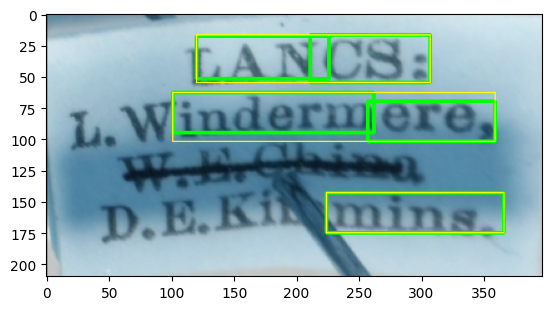

(<matplotlib.image.AxesImage at 0x15b162710>, None)

In [351]:
for group in groups:

    boxes_array = np.array(group)
    
    # Find the minimum and maximum coordinates along the x and y axes
    min_x = np.min(boxes_array[:, :, 0])
    min_y = np.min(boxes_array[:, :, 1])
    max_x = np.max(boxes_array[:, :, 0])
    max_y = np.max(boxes_array[:, :, 1])
    
    # Create a bounding rectangle using the min and max coordinates
    bounding_rectangle = np.array([
        [min_x, min_y],
        [max_x, max_y],
    ])

    print(bounding_rectangle)
    p1, p2 = bounding_rectangle

    cv2.rectangle(image, p1, p2, (255, 255, 0), 1)

plt.imshow(image), plt.show() 

In [335]:
import numpy as np
from sklearn.cluster import KMeans

# List of intervals as arrays
intervals = np.array([(0, 4), (2, 6), (8, 10), (9, 15), (18, 23)])

# Transform intervals into points in space (e.g., using midpoint of intervals)
points = np.array([(start + end) / 2 for start, end in intervals])

# Perform KMeans clustering
n_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(points)

# Initialize clusters
clusters = [[] for _ in range(n_clusters)]

# Assign intervals to clusters
for interval, cluster_label in zip(intervals, kmeans.labels_):
    clusters[cluster_label].append(interval)

# Print the grouped intervals
for cluster in clusters:
    print(cluster)


ModuleNotFoundError: No module named 'sklearn'

In [333]:
!pip install scikit-learn

  Using cached scikit_learn-1.3.0-cp310-cp310-macosx_10_9_x86_64.whl (10.2 MB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [ ]:
# Load the EAST text detection model
east_model =   # Path to the EAST model file

# image = cv2.imread(str(ASSETS_DIR / 'car_wash.png'))

image = deepcopy(images[3])
orig = image.copy()

(H, W) = image.shape[:2]
(newW, newH) = (320, 320)

rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))

(H, W) = image.shape[:2]

net = cv2.dnn.readNet(str(ASSETS_DIR / east_model))

# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")



# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))


# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]
    
    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < 0.5:
            continue
        
        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)
        
        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        
        cos = np.cos(angle)
        sin = np.sin(angle)
        
        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]
        
        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

plt.imshow(orig), plt.show()

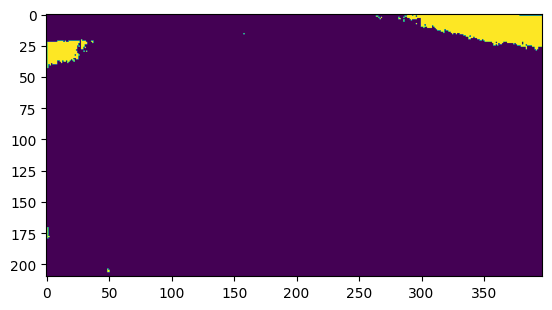

(<matplotlib.image.AxesImage at 0x157a804c0>, None)

In [150]:
gray_image = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# Apply thresholding to segment the text region
_, thresholded = cv2.threshold(gray_image, 220, 255, cv2.THRESH_BINARY)

plt.imshow(thresholded), plt.show()

# # Inverse the thresholded image to get the background mask
# background_mask = cv2.bitwise_not(thresholded)

# # Create a new image with the same dimensions as the original image
# new_background = np.zeros_like(image)

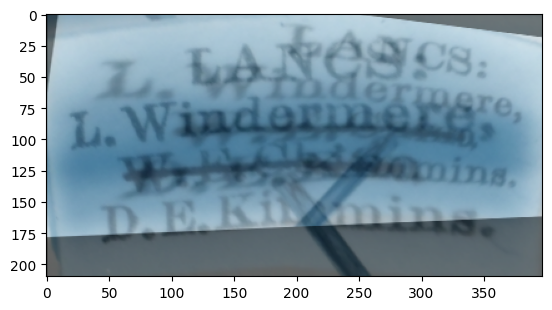

In [35]:
# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Calculate homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp the second image to align with the first image
aligned_image2 = cv2.warpPerspective(image2, H, (image1.shape[1], image1.shape[0]))

# Create a blended image
blended_image = cv2.addWeighted(image1, 0.5, aligned_image2, 0.5, 0)
plt.imshow(blended_image)
plt.show()

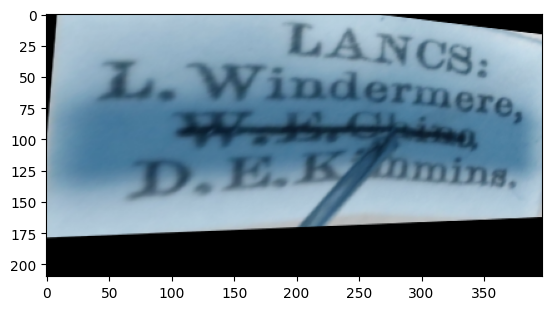

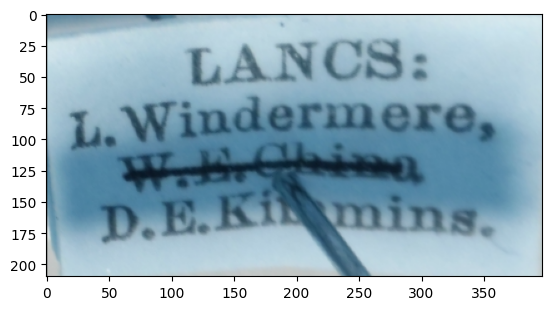

In [23]:
# Initialize a brute force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# Match descriptors using KNN
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to keep good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Convert keypoints to Point2f
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# print(src_pts)

src_pts2 = np.float32([m.pt for m in matched1]).reshape(-1, 1, 2)
dst_pts2 = np.float32([m.pt for m in matched2]).reshape(-1, 1, 2)


# Use RANSAC to estimate homography
H, mask = cv2.findHomography(src_pts2, dst_pts2, cv2.RANSAC, 5.0)

# Apply the estimated homography to warp the second image
aligned_image = cv2.warpPerspective(image2, H, (image1.shape[1], image1.shape[0]))

plt.imshow(aligned_image)
plt.show()
plt.imshow(image1)
plt.show()

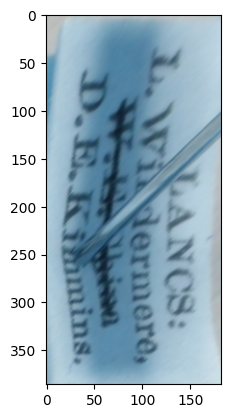

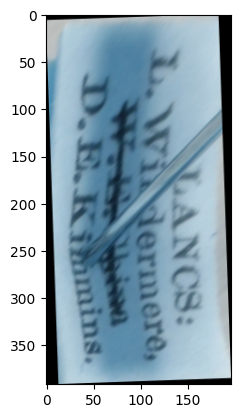

Page number: 0
Orientation in degrees: 270
Rotate: 90
Orientation confidence: 0.34
Script: Devanagari
Script confidence: 2.00



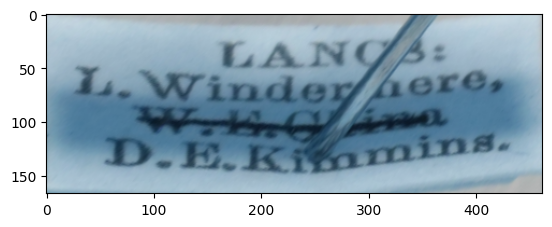

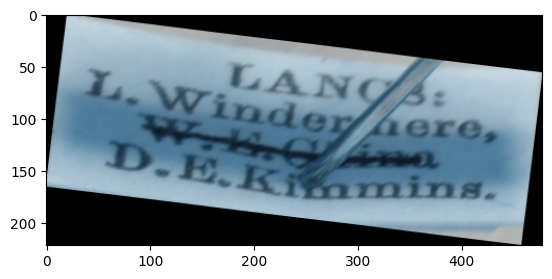

Page number: 0
Orientation in degrees: 180
Rotate: 180
Orientation confidence: 0.03
Script: Cyrillic
Script confidence: 3.33



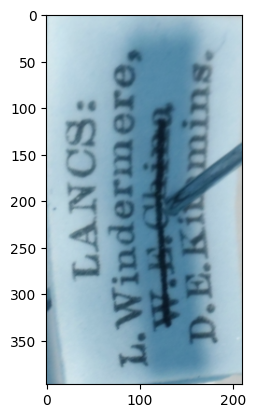

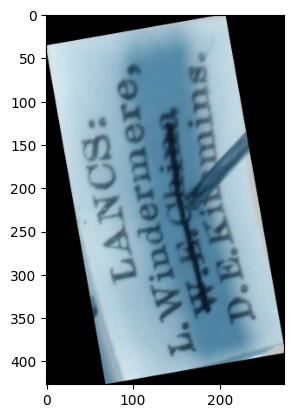

Page number: 0
Orientation in degrees: 90
Rotate: 270
Orientation confidence: 0.06
Script: Devanagari
Script confidence: 0.00



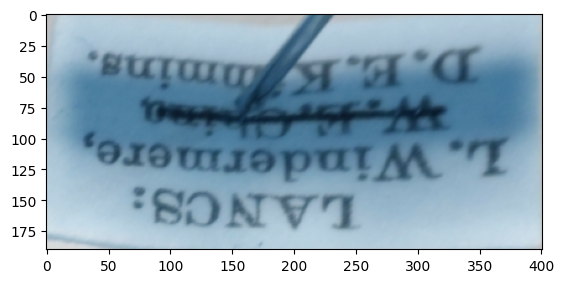

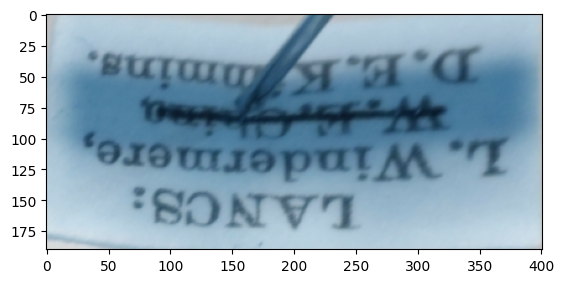

Page number: 0
Orientation in degrees: 0
Rotate: 0
Orientation confidence: 0.12
Script: Latin
Script confidence: 0.00



In [68]:
import imutils
img = deepcopy(view.image)


def removeReps(T, F):
    # Remove repeated points in a curve.
    n = len(T)
    newT = []
    newF = []
    newT.append(T[0])
    newF.append(F[0])
    k = 0
    for i in range(1, n):
        if (T[i] != newT[k]) or (F[i] != newF[k]):
            newT.append(T[i])
            newF.append(F[i])
            k = k + 1
    return newT, newF

def warp_label(image, box):

    max_x = round(max([box.edges['a_b'].length, box.edges['c_d'].length])) - 1
    max_y = round(max([box.edges['b_c'].length, box.edges['d_a'].length])) - 1
    
    dest = np.float32([
        (0, max_x), #A
        (0, 0), #B
        (max_y, 0), #C
        (max_y, max_x) #D
    ])
    
    src = np.float32(list(box.vertices.values()))
    M = cv2.getPerspectiveTransform(src, dest)
    
    return cv2.warpPerspective(image,M,(max_y, max_x),flags=cv2.INTER_LINEAR)

def basic_threshold(img, p):
    # Global thresholding on a grey-scaled images based on a threshold value, p.
    if np.max(img) < 2:  # Assumes colour map is either between 0-1, or 0-255.
        mx = 1
    else:
        mx = 255
    thresh = deepcopy(img)
    thresh[np.where(img < p)] = 0
    thresh[np.where(img >= p)] = mx

    return thresh

def reject_outliers(data, index, m=10):
    # Function used to remove outliers from arrays. This is based on the median of the data.
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / mdev if mdev else 0.0
    inds = np.where(s < m)[0]
    if len(index) != 0:
        return data[inds], index[inds]
    else:
        return data[inds]    

def adjust_alignment(
    image_orig,
    angles=np.linspace(-10, 10, 21),
    percentile=15,
    min_contour_height=15,
    height_prop=30,
    return_col=False,
):

    k = 0

    opt_angle = 0
    max_len = 0
    max_ind = 0

    all_lens = []

    # Convert image to greyscale:
    image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    # Compute threshold value based on percentile (not including black pixels):
    bound = np.percentile(
        image.flatten()[np.where(image.flatten() != 0)[0]], percentile
    )
    # Global thresholding:
    image_thresh = basic_threshold(image, bound)

    for i, angle in enumerate(angles):
        # Rotate image based on angle:
        seg = imutils.rotate_bound(image_thresh, angle)
        # Find contours:
        contours = measure.find_contours(seg, 0.8)
        # Filter for contours whose number of points isn't an outlier. This step is required to remove
        # contours around the label hence the aim is to get the contours of characters only.
        lens_ = [len(c[:, 0]) for c in contours]
        _, inds = reject_outliers(
            np.array(lens_), np.int_(np.linspace(0, len(lens_) - 1, len(lens_)))
        )
        # Save y coordinates of filtered contours:
        min_height = min([min_contour_height, np.shape(image)[0] / height_prop])
        all_y = []
        for i in inds:
            c = contours[i]
            x = c[:, 1]
            y = c[:, 0]
            if (len(x) > 10) & (
                (max(y) - min(y)) > min_height
            ):  # We focus on contours > 10 points. This number was chosen arbitrarily to exclude illegible/"accidental" contours.
                # Remove repeated points in contour.
                x, y = removeReps(np.round(x), np.round(y))
                all_y.extend(y)
        # Find number of points from the contours that lie in each horizontal strip across the thresholded image.
        lens = [
            len(np.where(np.array(all_y) == p)[0]) for p in range(0, np.shape(seg)[1])
        ]
        # Compute maximum across the horizontal strips.
        v = np.argmax(lens)
        m = max(lens)
        all_lens.append(lens)
        if m > max_len:
            max_len = deepcopy(m)
            max_ind = deepcopy(v)
            opt_angle = deepcopy(angle)

    rotated_img = imutils.rotate_bound(image, opt_angle)
    if return_col == True:
        return imutils.rotate_bound(image_orig, opt_angle)
    else:
        return opt_angle, max_len, max_ind, all_lens, rotated_img

warped_labels = []
for view in specimen:
    img = deepcopy(view.image)
    box = view.quads[1]
    # img = box.visualise(img)
    # plt.imshow(img)
    # plt.show()      
    warped_label = warp_label(view.image, box)
    optimal_angle = adjust_alignment(warped_label, np.linspace(-10, 10, 21))[0]
    adjusted_label = imutils.rotate_bound(warped_label, optimal_angle)    
    plt.imshow(warped_label)
    plt.show()

    plt.imshow(adjusted_label)
    plt.show()

    x = pytesseract.image_to_osd(warped_label, config="--psm 0 -c min_characters_to_try=5 script=Latin",)
    print(x)    

    warped_labels.append(warped_label)


In [79]:
import pytesseract

def tesseract_orientation_with_binarization_thresholding(
    image, threshold_values=[30, 40, 50, 60]
):
    rotation_confidence_ = -1
    rotation_ = 0
    best_binarized_image = deepcopy(image)
    for thresh in threshold_values:
        bI = bin_image(image, bound_percentile=thresh)
        try:
            rotation, rotation_confidence = get_rotation_basic(bI)
            if rotation_confidence > rotation_confidence_:
                rotation_confidence_ = deepcopy(rotation_confidence)
                rotation_ = deepcopy(rotation)
                best_binarized_image = deepcopy(bI)
        except:
            # raise
            pass

    return rotation_[0], rotation_[1], rotation_confidence_, best_binarized_image


def get_rotation_basic(image, values=np.int_(np.linspace(3, 10, 8))):

    osd_, _ = get_osd(image, values)
    rotation_confidence = get_osd_confidence(osd_)
    rotation = np.int_(re.findall("\d+", osd_)[1:3])

    return rotation, rotation_confidence


def get_osd(image, min_char_values):
    max_total = min(min_char_values)
    osd = "N/A"
    for j in min_char_values:
        try:
            osd = pytesseract.image_to_osd(
                image,
                config="--psm 0 -c min_characters_to_try=" + str(j) + " script=Latin",
            )
            max_total = j
        except:
            pass
    return osd, max_total


def get_osd_confidence(osd):
    k1 = re.search("Orientation confidence: ", osd).span()[1]
    k2 = re.search("\nScript", osd).span()[0]
    rot = osd[k1:k2]
    return float(rot)


def max_ocr_length_orientation(
    image, threshold_values=[30, 40, 50, 60], angles=[0, 90, 180, 270]
):
    ocr_longest = ""
    best_angle = -10
    for angle in angles:
        I = imutils.rotate_bound(image, angle)
        ocr_ = ""
        for thresh in threshold_values:
            try:
                bI = bin_image(I, bound_percentile=thresh)
                ocr_results = pytesseract.image_to_string(
                    bI, config="--psm 11 script=Latin"
                )
                ocr_res = " ".join(re.findall("\w+", ocr_results))
            except:
                ocr_res = ""
            if len(ocr_res) > len(ocr_):
                ocr_ = deepcopy(ocr_res)
        if len(ocr_) > len(ocr_longest):
            ocr_longest = deepcopy(ocr_)
            best_angle = deepcopy(angle)

    return best_angle

def bin_image(image_orig, bound_percentile=50):
    # Aim: threshold image based on median colour.

    # Input: image.
    # Output: binarized image.

    image = cv2.cvtColor(image_orig, cv2.COLOR_BGR2GRAY)
    m = np.percentile(image.flatten(), bound_percentile)
    image2 = deepcopy(image)
    image2[np.where(image > m)] = 255
    image2[np.where(image < m)] = 0
    return image2

def adjust_and_rotate_warped_label(warped_label):
    # Input: warped label.
    # Output: Optimally rotated label.

    # 1) Minor adjustment in label angle:
    optimal_angle = adjust_alignment(warped_label, np.linspace(-10, 10, 21))[0]
    adjusted_label = imutils.rotate_bound(warped_label, optimal_angle)
    # 2) Check the orientation of label with an optimized tesseract orientation tool:
    # Note that as this method isn't up to standard yet, we only accept the orientation
    # based on additional criteria, which also includes a backup tool to predict orientation.
    # This backup tool simply rotates the images 0,90,180,270 degrees and counts the number of
    # letters in each binarized image, using tesseract.
    (
        orientation,
        angle_to_rotate,
        confidence,
        best_binarized_image,
    ) = tesseract_orientation_with_binarization_thresholding(adjusted_label)
    if (orientation == 180) or (confidence > 0.5):
        rotated_label = imutils.rotate_bound(adjusted_label, angle_to_rotate)
    else:
        new_orientation_angle = max_ocr_length_orientation(adjusted_label)
        if new_orientation_angle == angle_to_rotate:
            rotated_label = imutils.rotate_bound(adjusted_label, angle_to_rotate)
        else:
            rotated_label = deepcopy(adjusted_label)
    return rotated_label, best_binarized_image

rotated_labels = []
binarized_labels = []
    
for warped_label in warped_labels:
    rotated_label, binarized_label = adjust_and_rotate_warped_label(
        warped_label
    )
    rotated_labels.append(rotated_label)
    binarized_labels.append(binarized_label)




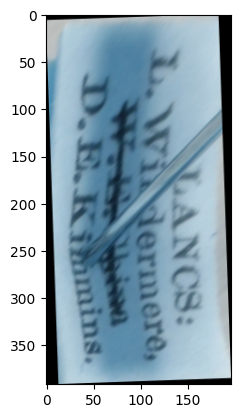

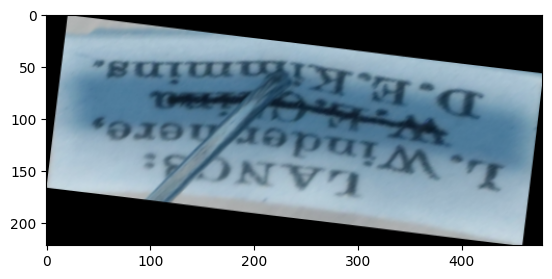

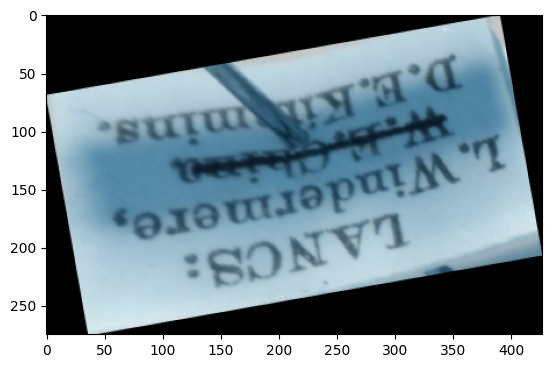

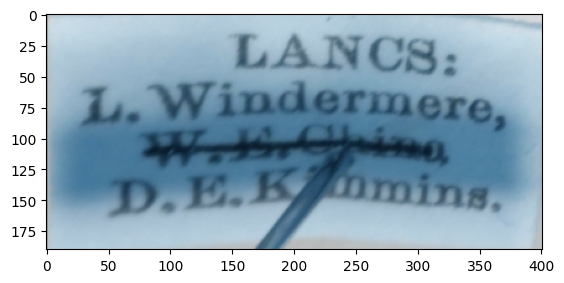

In [72]:
for rotated_label in rotated_labels:
    plt.imshow(rotated_label)
    plt.show()

In [80]:
def select_template_warped_label(all_rotated_warped_labels, all_binarized_labels):
    # Input: rotated_labels, binarized labels
    # Output: template based on one of the four rotated_labels.

    longest_label_text_length = 0
    template_warped_label = all_rotated_warped_labels[0]
    for ind, rotated_label in enumerate(all_rotated_warped_labels):
        binarized_label = all_binarized_labels[ind]
        ocr_results = pytesseract.image_to_string(
            binarized_label, config="--psm 11 script=Latin"
        )
        text_in_label = " ".join(re.findall("\w+", ocr_results))
        if len(text_in_label) > longest_label_text_length:
            longest_label_text_length = len(text_in_label)
            template_warped_label = deepcopy(rotated_label)
    return template_warped_label

template_warped_label = select_template_warped_label(
    rotated_labels, binarized_labels
)

template_warped_label = rotated_labels[3]

rotated_labels2 = [
    imutils.rotate_bound(rotated_labels[0], 270),
    imutils.rotate_bound(rotated_labels[1], 180)  
]



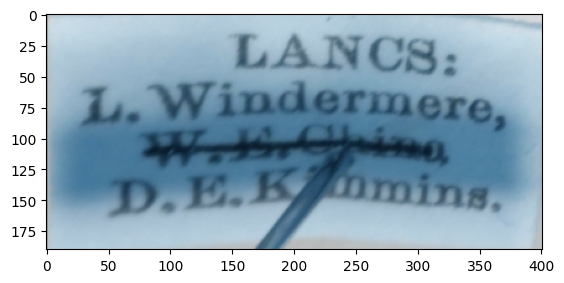

In [83]:
plt.imshow(template_warped_label)
plt.show()

In [84]:
def align_warped_label_to_template(
    image, template, matches_bound=0.9, max_no_matches=1000
):
    # Aim: align an image with a template.

    # Input: image / template.
    # Ouput: aligned image.

    img1_color = deepcopy(image)  # Image to be aligned.
    img2_color = deepcopy(template)  # Reference image.

    # Convert to grayscale.
    img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
    height, width = img2.shape

    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)

    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(img1, None)
    kp2, d2 = orb_detector.detectAndCompute(img2, None)

    # Match features between the two images.
    # We create a Brute Force matcher with
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match the two sets of descriptors.
    matches = matcher.match(d1, d2)

    # Sort matches on the basis of their Hamming distance.
    dists = [m.distance for m in matches]
    lst = [matches[i] for i in np.argsort(dists)]
    matches = tuple(lst)

    # Take the top 90 % matches forward.
    matches = matches[: int(len(matches) * matches_bound)]

    # Filter matches (ASJ edit):

    lines, new_index = filter_matches_new(matches, kp1, kp2, img1)

    lines_filtered = np.array(lines)[new_index]

    matches = tuple([m for i, m in enumerate(matches) if i in new_index])

    no_of_matches = len(matches)

    if no_of_matches > max_no_matches:
        matches = matches[:max_no_matches]
        no_of_matches = len(matches)
        lines_filtered = lines_filtered[:max_no_matches]

    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))

    for i in range(len(matches)):
        p1[i, :] = kp1[matches[i].queryIdx].pt
        p2[i, :] = kp2[matches[i].trainIdx].pt

    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)

    # Use this matrix to transform the
    # colored image wrt the reference image.
    transformed_img = cv2.warpPerspective(img1_color, homography, (width, height))

    return transformed_img, lines, lines_filtered, homography

def filter_matches_new(matches, kp1, kp2, template_image):

    lines = get_matches(matches, kp1, kp2, template_image)

    gradients = []
    gradients_index = []
    for i, l in enumerate(lines):
        grad = get_grad(l)
        gradients.append(grad)
        gradients_index.append(i)
    try:
        LB, UB = outlier_bounds(gradients)
    except:
        LB, UB = [0, 0]

    pos_gradients_filtered_index = []
    neg_gradients_filtered_index = []

    for i, g in enumerate(gradients):
        if LB <= g <= UB:
            if g >= 0:
                pos_gradients_filtered_index.append(gradients_index[i])
            else:
                neg_gradients_filtered_index.append(gradients_index[i])

    all_new_index = [pos_gradients_filtered_index, neg_gradients_filtered_index]
    k = np.argmax([len(I) for I in all_new_index])
    gradients_filtered_index = all_new_index[k]

    return lines, gradients_filtered_index


def get_matches(matches, kp1, kp2, img):

    lines = []
    for v in range(len(matches)):
        i1, i2 = [matches[v].queryIdx, matches[v].trainIdx]
        x1 = kp1[i1].pt[0]
        y1 = kp1[i1].pt[1]
        x2 = kp2[i2].pt[0] + np.shape(img)[1]
        y2 = kp2[i2].pt[1]
        lines.append([[x1, x2], [y1, y2]])
    return lines


def get_grad(l):
    return np.round((l[1][1] - l[1][0]) / (l[0][1] - l[0][0]), 6)


def outlier_bounds(values, alpha=1.5):
    IQR_ = alpha * (np.percentile(values, 75) - np.percentile(values, 25))
    UB = np.percentile(values, 75) + IQR_
    LB = np.percentile(values, 25) - IQR_
    return LB, UB    

def align_warped_labels(all_rotated_warped_labels, template_warped_label):
    # Input: all rotated labels, template_label
    # Ouput: all labels aligned to template.
    aligned_labels = []
    for warped_label in all_rotated_warped_labels:
        if np.array_equal(warped_label, template_warped_label):
        # if warped_label == template_warped_label:
            aligned_labels.append(warped_label)
        else:
            try:
                aligned_label = align_warped_label_to_template(
                    warped_label, template_warped_label
                )[0]
                aligned_labels.append(aligned_label)
            except:
                raise
                pass

    if len(aligned_labels) == 0:
        aligned_labels = deepcopy(all_rotated_warped_labels)
    return aligned_labels

aligned_labels = align_warped_labels(rotated_labels2, template_warped_label)

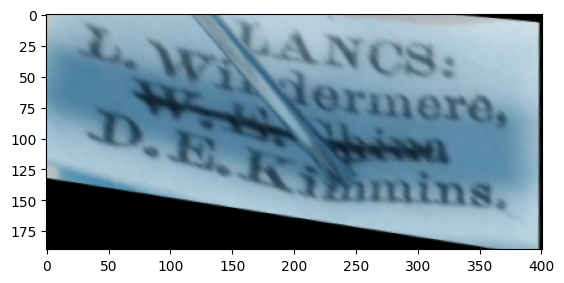

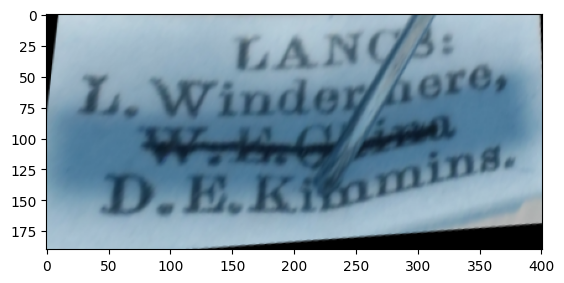

In [85]:
for rotated_label in aligned_labels:
    plt.imshow(rotated_label)
    plt.show()

In [53]:
def is_label_good(label):
    # Input: label
    # Output: classification of whether label is good or bad (np.bool).
    return True
    classification = good_or_bad_label_predictor(label)
    good_or_bad = classification["instances"].pred_classes[0].item()
    return np.bool(good_or_bad)


def exclude_bad_labels_with_template_pixel_difference(
    aligned_labels, template_warped_label
):
    # Input: aligned labels, template label.
    # Output: filtered labels (that are not too different from template).
    sum_of_pixel_differences_all = [
        np.sum(abs(template_warped_label - label)) for label in aligned_labels
    ]
    sum_of_pixel_differences = [
        diffsum for diffsum in sum_of_pixel_differences_all if diffsum > 0
    ]
    upper_bound_pixel_diffsum = np.median(sum_of_pixel_differences) + (
        np.percentile(sum_of_pixel_differences, 75)
        - np.percentile(sum_of_pixel_differences, 25)
    )
    filtered_aligned_labels = []
    for ind, label in enumerate(aligned_labels):
        if sum_of_pixel_differences_all[ind] < upper_bound_pixel_diffsum:
            filtered_aligned_labels.append(label)
    return filtered_aligned_labels

def find_all_good_labels(aligned_labels, template_warped_label):
    # Input: aligned labels
    # Output: good labels.
    try:
        filtered_aligned_labels = exclude_bad_labels_with_template_pixel_difference(
            aligned_labels, template_warped_label
        )
    except:
        filtered_aligned_labels = deepcopy(aligned_labels)
    filtered_labels = []
    for label in filtered_aligned_labels:
        if is_label_good(label) is True:
            filtered_labels.append(label)
    if len(filtered_labels) == 0:
        filtered_labels = deepcopy(aligned_labels)
    return filtered_labels

filtered_labels = find_all_good_labels(aligned_labels, template_warped_label)


NameError: name 'aligned_labels' is not defined

In [52]:
def merge_label(all_labels, method=0):
    # Aim: merge multiple labels together.

    # Input: label images to merge.
    # Output: merged label.

    """
    Method 0 - original method by Ginger (https://github.com/NaturalHistoryMuseum/ALICE/blob/master/ALICE/models/viewsets.py#L38-L49)
    Method 1 - alternative method (darkest values per pixel)
    """

    if method == 0:
        I = np.median(np.stack([v for v in all_labels]), axis=0)
        merged_label = np.array(I, dtype="uint8")
    else:
        bw_images = []
        bw_images_mx = []
        for img in all_labels:

            print(img.shape)
            
            image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            bw_images.append(image)
            image2 = deepcopy(image)
            image2[np.where(image == 0)] = 254
            bw_images_mx.append(image2)

        merged_label = np.min(bw_images_mx, 0)

    return merged_label

def merge_aligned_labels(filtered_labels):
    # Input: all filtered labels.
    # Output: merged label.
    try:
        merged_label = merge_label(filtered_labels, method=0)
    except:
        merged_label = merge_label(filtered_labels, method=1)
    return merged_label
    

merged_label = merge_aligned_labels(filtered_labels)

NameError: name 'filtered_labels' is not defined

In [ ]:
plt.imshow(merged_label)
plt.show()

In [ ]:
from pytesseract import Output

x = pytesseract.image_to_osd(adjusted_label, config="--psm 0 -c min_characters_to_try=5 script=Latin",)
print(x)

In [ ]:
plt.imshow(adjusted_label)
plt.show()

In [ ]:
plt.imshow(x)
plt.show()

In [ ]:
x = visualise_mask(view.image, view.predictions)
plt.imshow(x)
plt.show()

In [ ]:
def approx_best_fit_ngon(contours, n: int = 4) -> list[(int, int)]:
    """

    https://stackoverflow.com/questions/41138000/fit-quadrilateral-tetragon-to-a-blob
    """

    hull = cv2.convexHull(contours)
    hull = np.array(hull).reshape((len(hull), 2))

    # to sympy land
    hull = [sympy.Point(*pt) for pt in hull]

    # run until we cut down to n vertices
    while len(hull) > n:
        best_candidate = None

        # for all edges in hull ( <edge_idx_1>, <edge_idx_2> ) ->
        for edge_idx_1 in range(len(hull)):
            edge_idx_2 = (edge_idx_1 + 1) % len(hull)

            adj_idx_1 = (edge_idx_1 - 1) % len(hull)
            adj_idx_2 = (edge_idx_1 + 2) % len(hull)

            edge_pt_1 = sympy.Point(*hull[edge_idx_1])
            edge_pt_2 = sympy.Point(*hull[edge_idx_2])
            adj_pt_1 = sympy.Point(*hull[adj_idx_1])
            adj_pt_2 = sympy.Point(*hull[adj_idx_2])

            subpoly = sympy.Polygon(adj_pt_1, edge_pt_1, edge_pt_2, adj_pt_2)
            angle1 = subpoly.angles[edge_pt_1]
            angle2 = subpoly.angles[edge_pt_2]

            # we need to first make sure that the sum of the interior angles the edge
            # makes with the two adjacent edges is more than 180°
            if sympy.N(angle1 + angle2) <= sympy.pi:
                continue

            # find the new vertex if we delete this edge
            adj_edge_1 = sympy.Line(adj_pt_1, edge_pt_1)
            adj_edge_2 = sympy.Line(edge_pt_2, adj_pt_2)
            intersect = adj_edge_1.intersection(adj_edge_2)[0]

            # the area of the triangle we'll be adding
            area = sympy.N(sympy.Triangle(edge_pt_1, intersect, edge_pt_2).area)
            # should be the lowest
            if best_candidate and best_candidate[1] < area:
                continue

            # delete the edge and add the intersection of adjacent edges to the hull
            better_hull = list(hull)
            better_hull[edge_idx_1] = intersect
            del better_hull[edge_idx_2]
            best_candidate = (better_hull, area)

        if not best_candidate:
            raise ValueError("Could not find the best fit n-gon!")

        hull = best_candidate[0]

    # back to python land
    hull = [(int(x), int(y)) for x, y in hull]

    return hull

mask = view.masks[2]
contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Simplify contour - otherwise approx_best_fit_ngon takes many seconds
# Requires low epsilon < 10 otherwise approx vertices are out
epsilon = 5 
contours = cv2.approxPolyDP(contours[0], epsilon, True)

vertices = approx_best_fit_ngon(contours)

In [ ]:
vertices

In [ ]:
vertices

In [ ]:
img = deepcopy(view.image)

hull = cv2.convexHull(contours)
cv2.drawContours(img, [hull], -1, (0,255,255), 3)

plt.imshow(img)
plt.show()

In [ ]:
vertices

In [ ]:
# Move to UTILS



In [ ]:

            
        





    # TODO: Log


img = deepcopy(view.image)





for view in specimen:
    img = deepcopy(view.image)
    for mask in view.masks:
        quad = mask_to_quadrilateral(mask)
        img = quad.visualise(img)
        plt.imshow(img)
        plt.show()        

    break
    
        # if not quad.is_wellformed_label_shape():

    
    # quad.angles['a']
    
    # print(quad.angles)
    # break

    # quad = Quadrilateral(vertices)

    # print(vertices)

    


    # closest_point = max(vertices, key= lambda x: vertices[x][1])  

    # x = cv2.convexHull(np.array(vertices), clockwise=False)

    # print(closest_point)

    # print(list(vertices))

    # for vertice in :
    #     print(vertice)

    # vertices = OrderedDict(zip(['a', 'b', 'c', 'd'], iter_list_from_value(vertices, closest_point)))        

    # print(closest_point)
    # print(vertices.index(closest_point))

    # print(x)

    # print(vertices)
    # break
    
    # print(type(x))

    


    # break
    
    # if quad.is_valid_label_shape():
    #     pass

    
    # print(mask)

# quad = Quadrilateral(vertices)

In [ ]:
# for x in quad:
#     print(list(map(tuple, x)))



In [ ]:
quad.edges

In [ ]:
import math 




    